In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


data = pd.read_csv("ACE2_train_data.csv")

class ACE2Dataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, sep='\t', header=None)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {'id': self.data.iloc[idx, 0],
                  'sequence': self.data.iloc[idx, 2],
                  'label': self.data.iloc[idx, 3],
                  'binary_label': self.data.iloc[idx, 4],
                  'length': self.data.iloc[idx, 5]}

        return sample

ace2_dataset = ACE2Dataset('ACE2_train_data.csv')
ace2_dataloader = DataLoader(ace2_dataset, batch_size=32, shuffle=True)


<AxesSubplot: >

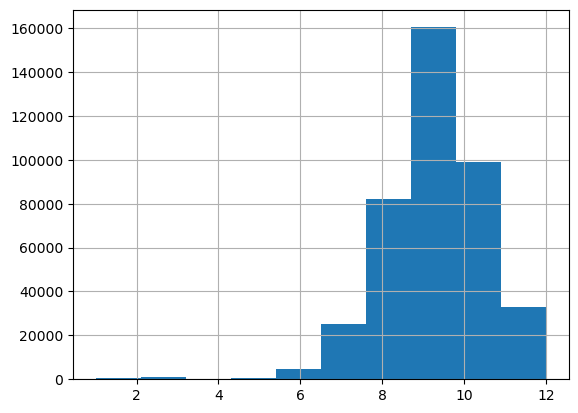

In [11]:
data.Distance.hist()

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=3, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 50)
        self.fc2 = nn.Linear(50, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, (h_n, c_n) = self.lstm1(x)
        x = self.fc1(h_n[-1])
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def fit_RNN(X_train, y_train, RNN_name):
    # define the model
    input_size = X_train.shape[2]
    hidden_size = 80
    output_size = 1
    model = RNN(input_size, hidden_size, output_size)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    
    # Train the model
    for epoch in range(50):
        running_loss = 0.0
        for i in range(len(X_train)):
            optimizer.zero_grad()
            inputs = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0)
            labels = torch.tensor(y_train[i], dtype=torch.float32).unsqueeze(0)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(X_train)
        print('Epoch [%d], train loss: %.4f' % (epoch+1, train_loss))
    
    # Save the model
    torch.save(model.state_dict(), RNN_name+"_RNN_All_3LSTM.pt")
    print(RNN_name+' RNN Model has been trained!')
    return model

